<a href="https://colab.research.google.com/github/JinnieL/Sentiment_Analysis/blob/main/01_%ED%99%98%EA%B2%BD_%EC%84%A4%EC%A0%95_%EB%B0%8F_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EC%A0%84%EC%B2%98%EB%A6%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [117]:
# 한글 깨짐을 방지한 폰트 다운로드
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [118]:
# 폰트 설정
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False

# Colab 환경 세팅

In [119]:
!pip install mxnet
!pip install gluonnlp==0.8.0
!pip install tqdm pandas
!pip install sentencepiece
!pip install transformers
!pip install torch

## KoBERT 모델을 Colab에 설치하기

In [120]:
# !pip install git+https://git@github.com/SKTBrain/KoBERT.git@master        # onnxruntime version error
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'
# !pip install onnxruntime

  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-jra89xce/kobert-tokenizer_014c230bae564f44846cdb0926dcb47e
  Running command git clone --filter=blob:none --quiet https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-jra89xce/kobert-tokenizer_014c230bae564f44846cdb0926dcb47e
  Resolved https://github.com/SKTBrain/KoBERT.git to commit 47a69af87928fc24e20f571fe10c3cc9dd9af9a3
  Preparing metadata (setup.py) ... done


In [121]:
# koBERT
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertModel

# Transformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [122]:
!pip install numpy==1.23.1

In [123]:
# Setting Library
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
from tqdm import tqdm, tqdm_notebook

In [124]:
import numpy as np
import pandas as pd

# Colab GPU 활용
device = torch.device("cuda:0")

# BERT 모델, Vocabulary 불러오기
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


# Data Preprocessing

In [125]:
conv_df = pd.read_excel("/content/Data/감성대화말뭉치(최종데이터)_Training.xlsx")
conv_df.head(10)

,Unnamed: 0,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템문장1,사람문장2,시스템문장2,사람문장3,시스템문장3
0,1,청년,여성,"진로,취업,직장",해당없음,분노,노여워하는,일은 왜 해도 해도 끝이 없을까? 화가 난다.,많이 힘드시겠어요. 주위에 의논할 상대가 있나요?,그냥 내가 해결하는 게 나아. 남들한테 부담 주고 싶지도 않고.,혼자 해결하기로 했군요. 혼자서 해결하기 힘들면 주위에 의논할 사람을 찾아보세요.,NaN,NaN
1,2,청년,여성,"진로,취업,직장",해당없음,분노,노여워하는,이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나.,급여가 줄어 속상하시겠어요. 월급이 줄어든 것을 어떻게 보완하실 건가요?,최대한 지출을 억제해야겠어. 월급이 줄어들었으니 고정지출을 줄일 수밖에 없을 것 같아.,월급이 줄어든 만큼 소비를 줄일 계획이군요.,NaN,NaN
2,3,청년,여성,"진로,취업,직장",해당없음,분노,노여워하는,회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...,회사 동료 때문에 스트레스를 많이 받는 것 같아요. 문제 해결을 위해 어떤 노력을 ...,잘 안 맞는 사람이랑 억지로 잘 지내는 것보단 조금은 거리를 두고 예의를 갖춰서 대...,스트레스받지 않기 위해선 인간관계에 있어 약간의 거리를 두는 게 좋겠군요.,NaN,NaN
3,4,청년,여성,"진로,취업,직장",해당없음,분노,노여워하는,직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 ...,관련 없는 심부름을 모두 하게 되어서 노여우시군요. 어떤 것이 상황을 나아질 수 있...,직장 사람들과 솔직하게 이야기해보고 싶어. 일하는 데에 방해된다고.,직장 사람들과 이야기를 해 보겠다고 결심하셨군요.,NaN,NaN
4,5,청년,여성,"진로,취업,직장",해당없음,분노,노여워하는,얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나.,무시하는 것 같은 태도에 화가 나셨군요. 상대방의 어떤 행동이 그런 감정을 유발하는...,상사인 나에게 먼저 인사하지 않아서 매일 내가 먼저 인사한다고!,항상 먼저 인사하게 되어 화가 나셨군요. 어떻게 하면 신입사원에게 화났음을 표현할 ...,NaN,NaN
5,6,청년,여성,"진로,취업,직장",해당없음,분노,노여워하는,직장에 다니고 있지만 시간만 버리는 거 같아. 진지하게 진로에 대한 고민이 생겨.,진로에 대해서 고민하고 계시는군요. 어떤 점이 고민인가요?,직장 상사한테 자주 지적을 받아. 그럴 때마다 이 업무는 나랑 맞지 않는 거 같이 ...,업무가 나와 맞지 않아 시간을 버리는 것 같이 느껴지셨군요.,NaN,NaN
6,7,청년,여성,"진로,취업,직장",해당없음,분노,노여워하는,성인인데도 진로를 아직도 못 정했다고 부모님이 노여워하셔. 나도 섭섭해.,부모님의 노여움에 섭섭하시군요. 이런 상황을 어떻게 해결하면 좋을까요?,부모님께 좀 더 시간을 달라고 해야겠어. 진로 테스트를 받아볼까 생각 중이야.,진로 테스트를 받아보겠다고 부모님께 말씀드릴 생각이군요.,NaN,NaN
7,8,청년,여성,"진로,취업,직장",해당없음,기쁨,느긋,퇴사한 지 얼마 안 됐지만 천천히 직장을 구해보려고.,천천히라도 직장을 구해 보려고 하시는군요. 특별한 이유가 있으신가요?,더 좋은 회사가 기다리고 있을지도 모르는데 쉬고 있기가 좀 그래.,좋은 일자리를 놓치고 싶지 않아 끊임없이 노력하시는군요. 하는 일이 잘 풀리시길 바라요.,NaN,NaN
8,9,청년,여성,"진로,취업,직장",해당없음,불안,걱정스러운,졸업반이라서 취업을 생각해야 하는데 지금 너무 느긋해서 이래도 되나 싶어.,취업에 대해 걱정이 되는군요.,응. 느긋함을 느끼는 내가 좀 싫었는데 걱정을 많이 하는 것보다는 낫다는 생각도 들어.,걱정보다는 느긋한 태도가 낫다고 생각하시는군요.,NaN,NaN
9,10,청년,여성,"진로,취업,직장",해당없음,기쁨,느긋,요즘 직장생활이 너무 편하고 좋은 것 같아!,직장생활이 편하고 좋으시다니 좋아 보여요. 다니고 계신 회사만의 장점이 있나요?,우리 회사는 복지가 정말 좋아! 내가 곧 출산하게 되는데 육아휴직 기간도 긴 데다가...,예비 엄마들에게는 정말 꿈의 회사인 것 같네요. 마음이 편하시겠어요.,NaN,NaN


In [126]:
conv_df[['감정_대분류', '사람문장1']].isnull().sum()

,0
감정_대분류,0
사람문장1,0


첫번째 발화에는 감정이 드러나도록 생성된 데이터 셋이고 첫 문장 발화 이후 시스템 응답이나 후속 대화들은 상황에 따라 감정상태가 포함되지 않는 경우도 있음.    
→ 감정상태가 확실하게 드러난 '사람문장1' 컬럼과 '감정_대분류' 컬럼을 사용

In [127]:
conv_df = conv_df[['사람문장1', '감정_대분류']]
conv_df.head(10)

,사람문장1,감정_대분류
0,일은 왜 해도 해도 끝이 없을까? 화가 난다.,분노
1,이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나.,분노
2,회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...,분노
3,직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 ...,분노
4,얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나.,분노
5,직장에 다니고 있지만 시간만 버리는 거 같아. 진지하게 진로에 대한 고민이 생겨.,분노
6,성인인데도 진로를 아직도 못 정했다고 부모님이 노여워하셔. 나도 섭섭해.,분노
7,퇴사한 지 얼마 안 됐지만 천천히 직장을 구해보려고.,기쁨
8,졸업반이라서 취업을 생각해야 하는데 지금 너무 느긋해서 이래도 되나 싶어.,불안
9,요즘 직장생활이 너무 편하고 좋은 것 같아!,기쁨


In [128]:
# Warning 무시
import warnings
warnings.filterwarnings('ignore')

  감정_대분류  count
0     기쁨   6126
1     당황   8756
2     분노   9160
3     불안   9320
4     상처   9143
5     슬픔   9125


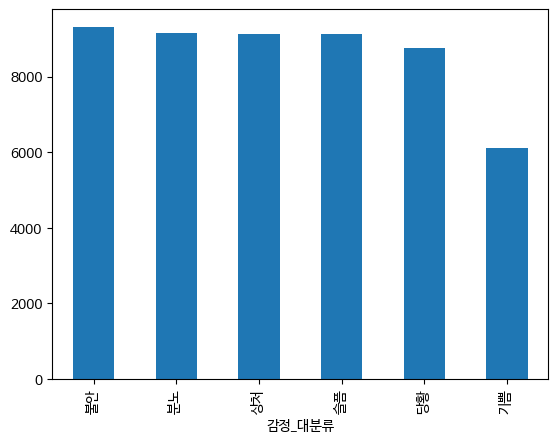

In [129]:
# label 개수 비교
conv_df['감정_대분류'].value_counts().plot(kind='bar')
print(conv_df.groupby('감정_대분류').size().reset_index(name='count'))

In [130]:
print(conv_df['감정_대분류'].value_counts())
print(conv_df['감정_대분류'].value_counts().sum())

감정_대분류
불안    9320
분노    9160
상처    9143
슬픔    9125
당황    8756
기쁨    6126
Name: count, dtype: int64
51630


In [131]:
sent_df = pd.read_excel("/content/Data/한국어_단발성_대화_데이터셋.xlsx")
sent_df.head(10)

,Sentence,Emotion,Unnamed: 2,Unnamed: 3,Unnamed: 4,공포,5468
0,언니 동생으로 부르는게 맞는 일인가요..??,공포,NaN,NaN,NaN,놀람,5898.0
1,그냥 내 느낌일뿐겠지?,공포,NaN,NaN,NaN,분노,5665.0
2,아직너무초기라서 그런거죠?,공포,NaN,NaN,NaN,슬픔,5267.0
3,유치원버스 사고 낫다던데,공포,NaN,NaN,NaN,중립,4830.0
4,근데 원래이런거맞나요,공포,NaN,NaN,NaN,행복,6037.0
5,남자친구가 떠날까봐요,공포,NaN,NaN,NaN,혐오,5429.0
6,이거 했는데 허리가 아플수도 있나요? ;;,공포,NaN,NaN,NaN,Total,38594.0
7,내가불안해서꾸는걸까..,공포,NaN,NaN,NaN,NaN,NaN
8,일주일도 안 남았당...ㅠㅠ,공포,NaN,NaN,NaN,NaN,NaN
9,약은 최대한 안먹으려고 하는데좋은 음시있나요?0,공포,NaN,NaN,NaN,NaN,NaN


In [132]:
sent_df[['Unnamed: 2',	'Unnamed: 3',	'Unnamed: 4']].value_counts()

,,,count
Unnamed: 2,Unnamed: 3,Unnamed: 4,



Sentence와 Emotion 컬럼을 제외하고 삭제처리

In [133]:
sent_df = sent_df[['Sentence', 'Emotion']]
sent_df.head(10)

,Sentence,Emotion
0,언니 동생으로 부르는게 맞는 일인가요..??,공포
1,그냥 내 느낌일뿐겠지?,공포
2,아직너무초기라서 그런거죠?,공포
3,유치원버스 사고 낫다던데,공포
4,근데 원래이런거맞나요,공포
5,남자친구가 떠날까봐요,공포
6,이거 했는데 허리가 아플수도 있나요? ;;,공포
7,내가불안해서꾸는걸까..,공포
8,일주일도 안 남았당...ㅠㅠ,공포
9,약은 최대한 안먹으려고 하는데좋은 음시있나요?0,공포


  Emotion  count
0      공포   5468
1      놀람   5898
2      분노   5665
3      슬픔   5267
4      중립   4830
5      행복   6037
6      혐오   5429


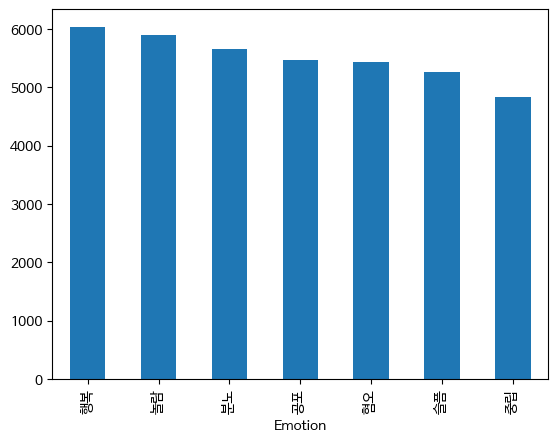

In [134]:
# label 개수 비교
sent_df['Emotion'].value_counts().plot(kind='bar')
print(sent_df.groupby('Emotion').size().reset_index(name='count'))

In [135]:
print(sent_df['Emotion'].value_counts())
print(sent_df['Emotion'].value_counts().sum())

Emotion
행복    6037
놀람    5898
분노    5665
공포    5468
혐오    5429
슬픔    5267
중립    4830
Name: count, dtype: int64
38594


1. 두 개 데이터 셋의 감정 레이블을 통일   
2. 데이터셋을 합치기
3. 레이블 카운트 다시 실행

In [136]:
print(conv_df['감정_대분류'].unique())
print(sent_df['Emotion'].unique())

['분노' '기쁨' '불안' '당황' '슬픔' '상처']
['공포' '놀람' '분노' '슬픔' '중립' '행복' '혐오']


In [137]:
conv_df[conv_df['감정_대분류'] == '당황'].sample(10)

,사람문장1,감정_대분류
34504,친구 장례식장에 갔는데 아들이 상주 노릇은 안 하고 술만 퍼마시더라. 한심해.,당황
33544,나 오늘 직장에서 업무 스트레스를 많이 느꼈어. 무척 힘들고 당황스러웠어.,당황
17906,분명 은퇴 후에도 일을 안 한 사람들은 원래 부자였을 것 같아서 부러워.,당황
24623,난 아내가 좋아서 장난을 쳤는데 화를 냈어.,당황
24868,집이 오래되어 비가 새는데 수리비가 부족해서 그냥 살고 있는 내가 너무 불쌍해.,당황
31892,왜 학교 폭력 가해자는 피해자에게 사과하지 않는 걸까? 그런걸 보면 가해자의 태도가...,당황
375,오늘 갑자기 나만 회사에서 해고를 당했어.,당황
33343,내 친구가 남자 친구가 다른 여자와 다정하게 식사하고 있는 걸 봤대. 근데 남자친구...,당황
47529,오늘 아이가 가출했어. 아무리 화가 나도 심한 말을 해선 안 되는 거였는데 왜 그랬을까?,당황
34507,친구가 다음 날 위내시경 검사라더니 술 먹자고 부르더라. 정말 한심했어.,당황


In [138]:
sent_df[sent_df['Emotion'] == '혐오'].sample(10)

,Sentence,Emotion
36932,이러다 다다음 대통령 정청래각이다,혐오
36467,20억 말고기 먹고시퍼 삼성에게 부탁하면 먹여주려나?,혐오
35237,야 무성이 니 이번기회에 졸개들 데리고 탈당 않하면 니 벼락 맞는데이지금 벼락실은 ...,혐오
34700,그러다 외계인이 중국으로 출장가겠담,혐오
37884,날씨 드럽게 안맞네 초가을이 아니라 초겨울 날씨구만,혐오
35191,"이보게들. 백화점에 13,000원짜리 밀가루면에 국물만 달랑있는 음식도 줄을서서 먹...",혐오
37968,승마는 스포츠에서 좀 빼자...,혐오
34579,너네 이거 있어 ? ㅋㅋ ㅋㅋ 못났다 못났어,혐오
36880,본인이 얘기하기 싫다는데 왜 그래 고문하겠다는건가?,혐오
36709,이런 기업은 하나님이 망하게 할거다. 니들이 좋아하는 하나님이~못된놈들. 젊은이들 ...,혐오


감성대화 말뭉치의 감정 label : 분노, 기쁨, 불안, 당황, 슬픔, 상처   
단발성 대화 세트의 감정 label : 공포, 놀람, 분노, 슬픔, 중립, 행복, 혐오    
두 데이터셋을 합치기 위해 감성대화 말뭉치의 label을 수정.

감정대화 말뭉치의 감정
- 분노 (유지)
- 기쁨 → 행복
- 불안 → 공포
- 상처 → 슬픔
- 당황 → 놀람

단발성 대화 세트의 감정
- 혐오 → 분노
- 중립 감정의 경우 데이터 균형성을 위해 일단 제거. 후에 활용 방안 다시 찾아볼것!

In [139]:
# 기쁨 → 행복 / 불안 → 공포 / 상처 → 슬픔
conv_df['감정_대분류'] = conv_df['감정_대분류'].replace('기쁨', '행복')
conv_df['감정_대분류'] = conv_df['감정_대분류'].replace('불안', '공포')
conv_df['감정_대분류'] = conv_df['감정_대분류'].replace('상처', '슬픔')
conv_df['감정_대분류'] = conv_df['감정_대분류'].replace('당황', '놀람')
sent_df['Emotion'] =sent_df['Emotion'].replace('혐오', '분노')
print(conv_df['감정_대분류'].unique())

['분노' '행복' '공포' '놀람' '슬픔']


In [140]:
# conv_df의 컬럼명 변경
conv_df = conv_df.rename(columns={'사람문장1': 'Sentence', '감정_대분류': 'Emotion'})
conv_df.sample(10)

,Sentence,Emotion
48161,우리 애들은 집을 나가고 우리 남편은 매일 화가 나 있어. 내 탓인 것만 같아.,놀람
21798,오늘 학교 화장실에서 친구들이 나를 가두고 변기 물을 뿌려서 구역질났어.,분노
49724,나는 왜 장애를 가지고 태어난 걸까? 내가 왜 이런 고통을 갖고 살아야 하는지 모르겠어.,놀람
51287,남편이 죽어서 삶의 이유가 사라졌어.,분노
18113,길에 택시를 잡는데 내가 휠체어를 타고 있는 것을 보고는 아무도 서지 않아.,놀람
22223,이번 승진에서 내가 주인공이 아니라니 충격적이야.,슬픔
7775,난 자식들한테 버려진 엄마 같다는 생각이 들어서 우울해.,슬픔
4102,오늘 최종면접에서 너무 황당한 질문을 들었어.,놀람
44424,질풍노도는 사춘기 때 끝난 줄 알았지. 당최 이 나이까지 이러고 있을지 몰랐다.,분노
12444,좋은 사람과 결혼을 하는 데도 불안하고 걱정돼.,공포


In [141]:
print(conv_df['Emotion'].value_counts())
print(conv_df['Emotion'].value_counts().sum())

Emotion
슬픔    18268
공포     9320
분노     9160
놀람     8756
행복     6126
Name: count, dtype: int64
51630


In [142]:
# 당황 감정을 제외하고 일단 합쳐보기
sent_df = sent_df[sent_df['Emotion'] != '중립']
sent_df = sent_df.reset_index(drop=True)
print(sent_df['Emotion'].unique())

['공포' '놀람' '분노' '슬픔' '행복']


In [143]:
# convDF와 sent_df 합치기
df = pd.concat([conv_df, sent_df])
df = df.reset_index(drop=True)
df.sample(10)

,Sentence,Emotion
18197,오늘 회사에서 업무 실수를 했어. 너무 당황스러웠어.,놀람
55255,그런데 이 차가 그냥 계속 제게 다가옵니다..,공포
469,내가 조금이라도 젊을 때 저축을 많이 하지 못한 것이 너무 후회돼.,놀람
64818,만날때마다 10억씩 까는 전략 어때?,분노
79579,예전에 이수경 드라마 '며느리전성시대'의 이수경역과 현실이 비슷해서 신기ㅋㅋㅋ팬입니다,행복
7411,일이 너무 많아서 집에 못 들어간 지 벌써 일주일은 된 것 같아.,슬픔
13686,엄마랑 아빠는 또 싸우고 언니랑 나는 눈치만 보고 있어.,슬픔
62211,뱅옵이 우리나라 회사가 되다니 ㅎㄷㄷ,놀람
10441,역시 건강이 만복의 근원이구나.,행복
81340,누구에게 비아그라른 처먹였을까알고있는 일본기자 글막고 고소하구 으그,분노


  Emotion  count
0      공포  14788
1      놀람  14654
2      분노  20254
3      슬픔  23535
4      행복  12163


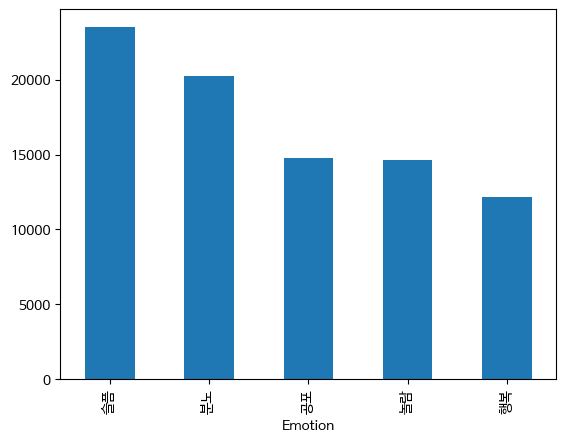

In [144]:
# label 개수 비교
df['Emotion'].value_counts().plot(kind='')
print(df.groupby('Emotion').size().reset_index(name='count'))

In [150]:
print(len(df[df['Emotion'] == '슬픔']) /len(df[df['Emotion'] == '행복']))

1.934966702293842
